In [1]:
%load_ext autoreload
%autoreload 2

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam

def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
        
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )
move_to_device(custom_sam_model)

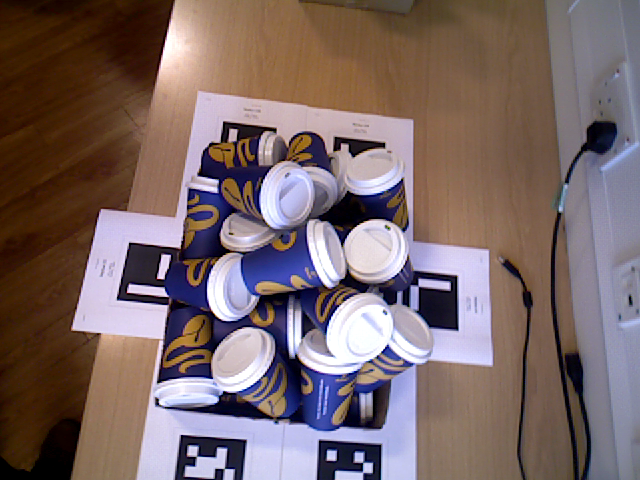

In [3]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000005.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [4]:
from torchvision.ops.boxes import batched_nms, box_area
import cv2
import numpy as np


def tighten_bboxes(sam_detections, device="cuda"):
    # Apply morphological opening - it does eorion then dilation to remove noise
    kernel = np.ones((5,5), np.uint8)

    filtered_masks = list()
    for mask in sam_detections["masks"].cpu():
        filtered_mask = cv2.morphologyEx(np.array(mask, dtype="uint8"), cv2.MORPH_OPEN, kernel)
        filtered_masks.append(torch.tensor(filtered_mask))
    sam_detections["masks"] = torch.stack(filtered_masks).to(device)
    return sam_detections


def _remove_very_small_detections(masks, boxes): # after this step only valid boxes, masks are saved, other are filtered out
    min_box_size = 0.05 # relative to image size 
    min_mask_size = 300/(640*480) # relative to image size assume the pixesl should be in range (300, 10000) need to remove them 
    max_mask_size = 10000/(640*480) 
    img_area = masks.shape[1] * masks.shape[2]
    box_areas = box_area(boxes) / img_area
    formatted_values = [f'{value.item():.6f}' for value in box_areas*img_area]
    mask_areas = masks.sum(dim=(1, 2)) / img_area
    keep_idxs = torch.logical_and(
        torch.logical_and(mask_areas > min_mask_size, mask_areas < max_mask_size),
        box_areas > min_box_size**2
    )

    return keep_idxs

noise_remove_sam_detections = tighten_bboxes(sam_detections)

keep_ids = _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"])

selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids)) if keep_ids[i]]

selected_sam_detections = {
    "masks" : torch.stack(selected_masks),
    "boxes" : torch.stack(selected_bboxes)
}

print(len(selected_sam_detections["masks"]))
print(len(sam_detections["masks"]))

68
98
